In [3]:
# Imports
import json
import os
os.chdir('..')
from src.plots import *
from src.utils import *

In [38]:
# load data and results
input_swbm_raw = pd.read_csv(os.path.join('data', 'Data_swbm_Germany.csv'))
input_swbm_de = prepro(input_swbm_raw)
input_swbm_raw = pd.read_csv(os.path.join('data', 'Data_swbm_Spain.csv'))
input_swbm_esp = prepro(input_swbm_raw)
input_swbm_raw = pd.read_csv(os.path.join('data', 'Data_swbm_Sweden.csv'))
input_swbm_swe = prepro(input_swbm_raw)
# swbm data
output_swbm_de = pd.read_csv(os.path.join('data', 'output', 'Data_swbm_Germany.csv'))
output_swbm_esp = pd.read_csv(os.path.join('data', 'output', 'Data_swbm_Spain.csv'))
output_swbm_swe = pd.read_csv(os.path.join('data', 'output', 'Data_swbm_Sweden.csv'))
# results 
with open(os.path.join('results', 'ger_output.json'), 'r') as json_file:
    calib_out_de = json.load(json_file)
with open(os.path.join('results', 'esp_output.json'), 'r') as json_file:
    calib_out_esp = json.load(json_file)
with open(os.path.join('results', 'swe_output.json'), 'r') as json_file:
    calib_out_swe = json.load(json_file)
# extract parameter values
const_swbm_params_de = calib_out_de[0].copy()
sinus_params_de = calib_out_de[-1].copy()
const_swbm_params_esp = calib_out_esp[0].copy()
sinus_params_esp = calib_out_esp[-1].copy()
const_swbm_params_swe = calib_out_swe[0].copy()
sinus_params_swe = calib_out_swe[-1].copy()

# Sinus curves of all sites

In [7]:
# load data and results
output_swbm = pd.read_csv(os.path.join('data', 'output', 'Data_swbm_Germany.csv'))
input_swbm_raw = pd.read_csv(os.path.join('data', 'Data_swbm_Germany.csv'))
input_swbm = prepro(input_swbm_raw)

with open(os.path.join('results', 'ger_output.json'), 'r') as json_file:
    calib_out = json.load(json_file)

const_swbm_params = calib_out[0].copy()
sinus_params = calib_out[-1].copy()

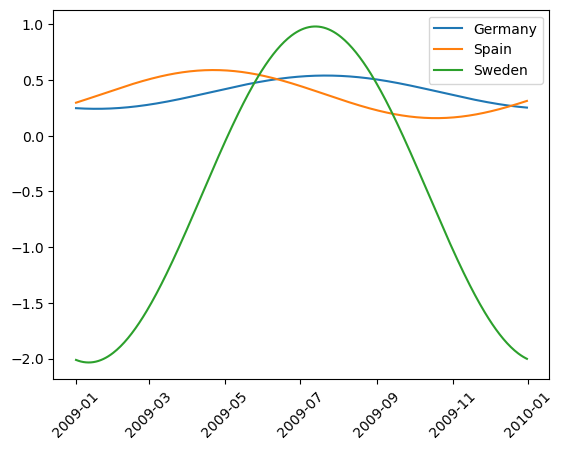

In [43]:
# plot our sinus for B0
year_mask = [date.year == 2009 for date in input_swbm['time']]
x_ticks = input_swbm['time'][year_mask]

for site, sinus_params in zip(('Germany', 'Spain', 'Sweden'),
                        [sinus_params_de, sinus_params_esp, sinus_params_swe]):
    sinus_b0 = seasonal_sinus(
        len(input_swbm),
        amplitude=sinus_params['amplitude'],
        freq=sinus_params['freq'],
        phase=sinus_params['phase'],
        center=sinus_params['center'],
        which='b0'
    )

    plt.plot(x_ticks, sinus_b0[year_mask], label=site)
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Germany

In [46]:
# Run SWBM without seasonal variation
moists, runoffs, ets, _ = predict_ts(input_swbm_de, const_swbm_params_de)
eval_df = eval_swbm(input_swbm_de,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')
eval_df = pd.concat((eval_df, eval_swbm(input_swbm_de, output_swbm_de, 'B0 seasonal')))

In [47]:
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,0.878503,0.0
1,None\nSeasonal,ro,0.642927,0.0
2,None\nSeasonal,le,0.899768,0.0
0,B0 seasonal,sm,0.908457,0.0
1,B0 seasonal,ro,0.650626,0.0
2,B0 seasonal,le,0.913306,0.0


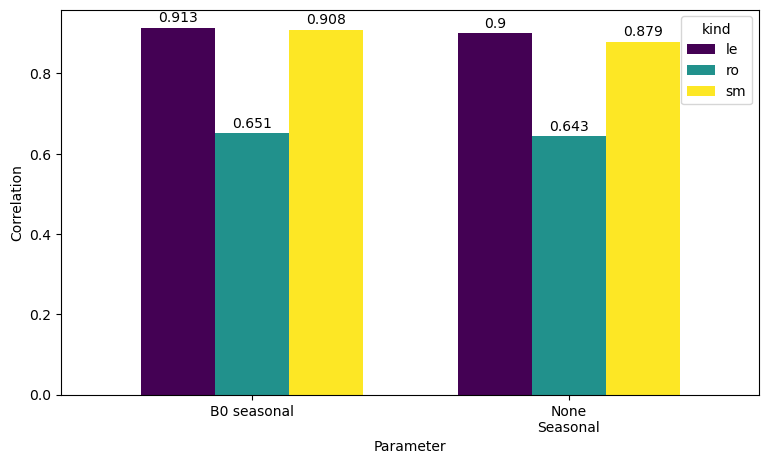

In [53]:
# PLot correlations
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr').sort_values(by='sm', ascending=False)

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(9, 5), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')
plt.xticks(rotation=0)
# Show the plot
plt.show()

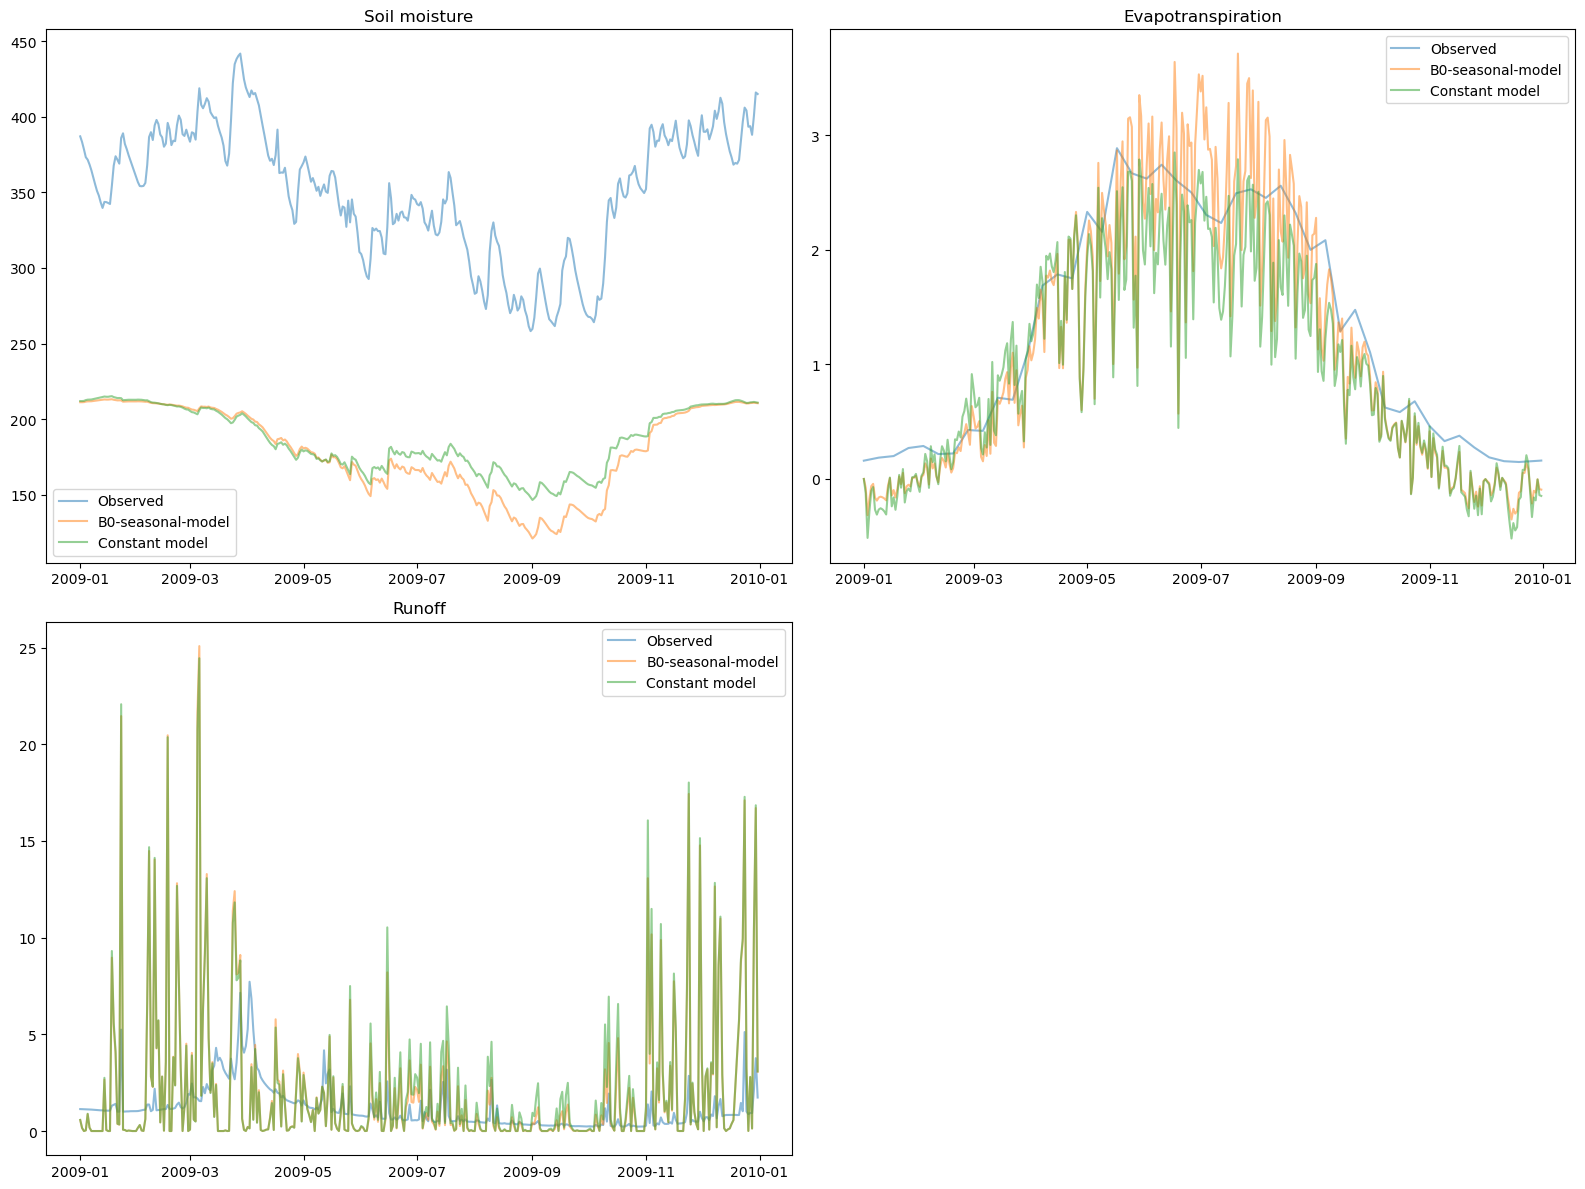

In [56]:
# visualize b0-model vs. constant-model vs. observed
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(x_ticks, input_swbm_de['sm'][year_mask], label='Observed', alpha=0.5)
ax[0, 0].plot(x_ticks, output_swbm_de['sm'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 0].plot(x_ticks, moists[year_mask], label='Constant model', alpha=0.5)
ax[0, 0].set_title('Soil moisture')
ax[0, 0].legend()

ax[0, 1].plot(x_ticks, input_swbm_de['le'][year_mask], label='Observed', alpha=0.5)
ax[0, 1].plot(x_ticks, output_swbm_de['le'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 1].plot(x_ticks, ets[year_mask], label='Constant model', alpha=0.5)
ax[0, 1].set_title('Evapotranspiration')
ax[0, 1].legend()

ax[1, 0].plot(x_ticks, input_swbm_de['ro'][year_mask], label='Observed', alpha=0.5)
ax[1, 0].plot(x_ticks, output_swbm_de['ro'][year_mask], alpha=0.5,
              label='B0-seasonal-model')
ax[1, 0].plot(x_ticks, runoffs[year_mask], label='Constant model', alpha=0.5)
ax[1, 0].set_title('Runoff')
ax[1, 0].legend()

ax[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

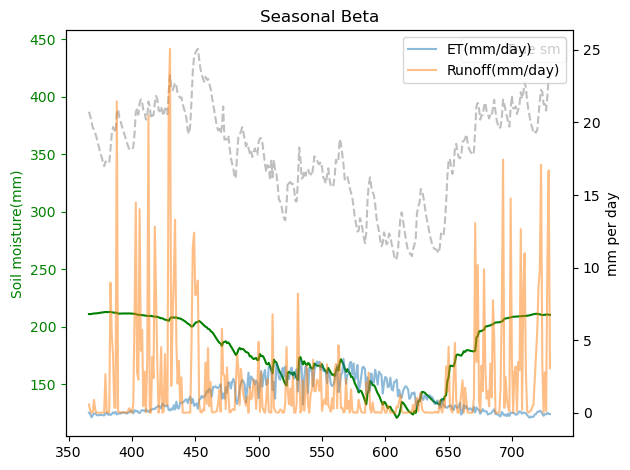

In [65]:
fig, ax = plt.subplots()
ax.set_title('Seasonal Beta')
ax, ax2 = plot_time_series(output_swbm_de['sm'][year_mask],
                           output_swbm_de['le'][year_mask],
                           output_swbm_de['ro'][year_mask], ax)
ax.plot(input_swbm_de['sm'][year_mask], label='True sm',
        linestyle='dashed', color='grey', alpha=0.5)
ax.set_ylabel('Soil moisture(mm)')
ax.legend()
ax2.legend()
plt.tight_layout()

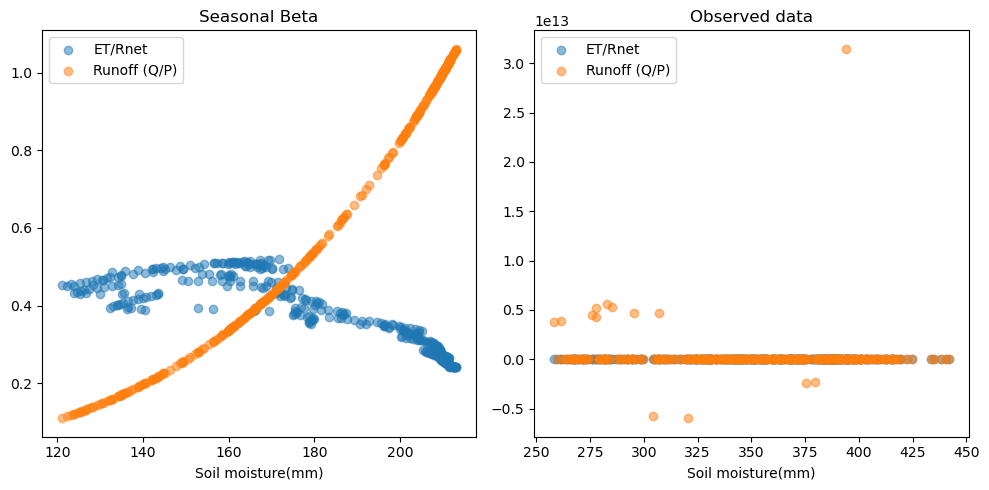

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_title('Seasonal Beta')
ax[0].scatter(output_swbm_de['sm'][year_mask],
           output_swbm_de['le'][year_mask] / input_swbm_de['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[0].scatter(output_swbm_de['sm'][year_mask],
           output_swbm_de['ro'][year_mask] / input_swbm_de['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[0].set_xlabel('Soil moisture(mm)')
ax[0].legend()

ax[1].set_title('Observed data')
ax[1].scatter(input_swbm_de['sm'][year_mask],
           input_swbm_de['le'][year_mask] / input_swbm_de['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[1].scatter(input_swbm_de['sm'][year_mask],
           input_swbm_de['ro'][year_mask] / input_swbm_de['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[1].set_xlabel('Soil moisture(mm)')
ax[1].legend()
plt.tight_layout()

# Spain

In [70]:
# Run SWBM without seasonal variation
moists, runoffs, ets, _ = predict_ts(input_swbm_esp, const_swbm_params_esp)
eval_df = eval_swbm(input_swbm_esp,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')
eval_df = pd.concat((eval_df, eval_swbm(input_swbm_esp, output_swbm_esp, 'B0 seasonal')))
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,0.880314,0.0
1,None\nSeasonal,ro,0.580754,0.0
2,None\nSeasonal,le,0.844069,0.0
0,B0 seasonal,sm,0.901130,0.0
1,B0 seasonal,ro,0.611012,0.0
2,B0 seasonal,le,0.879298,0.0


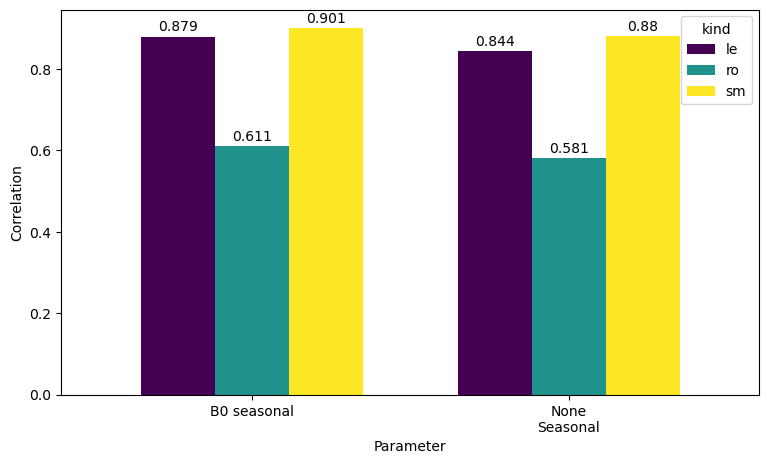

In [71]:
# PLot correlations
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr').sort_values(by='sm', ascending=False)

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(9, 5), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')
plt.xticks(rotation=0)
# Show the plot
plt.show()

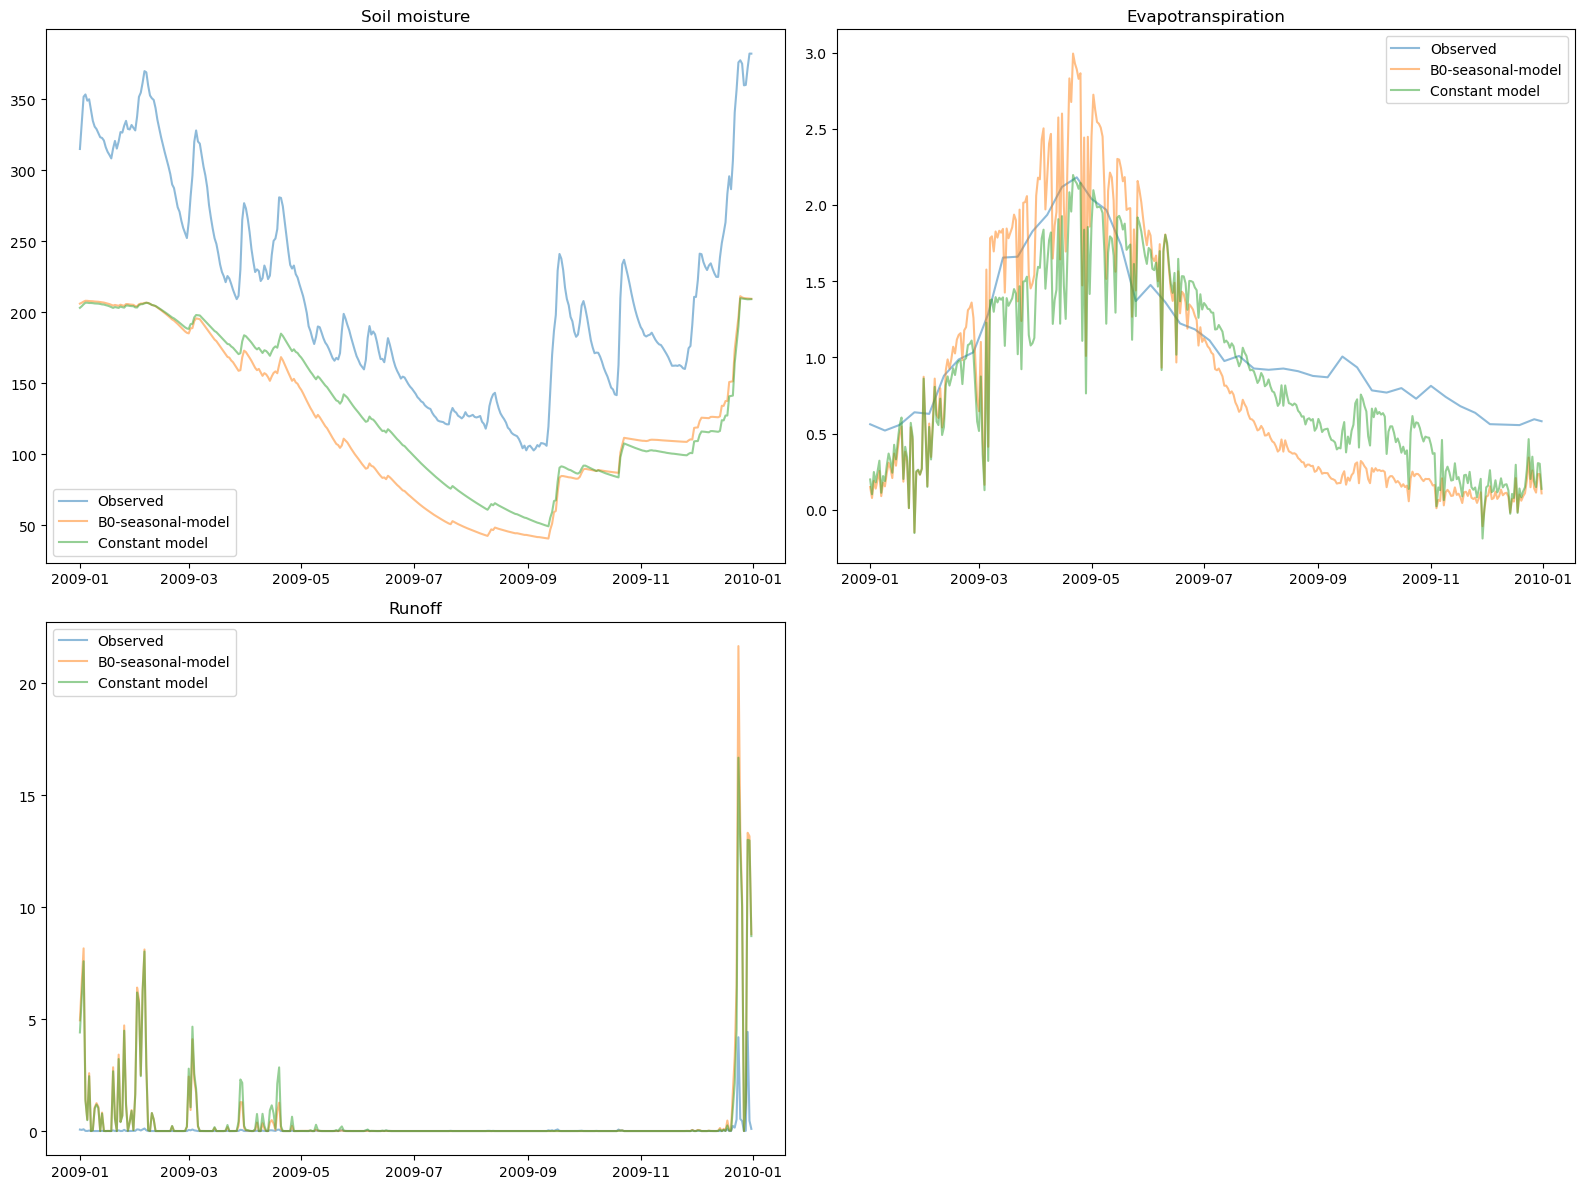

In [72]:
# visualize b0-model vs. constant-model vs. observed
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(x_ticks, input_swbm_esp['sm'][year_mask], label='Observed', alpha=0.5)
ax[0, 0].plot(x_ticks, output_swbm_esp['sm'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 0].plot(x_ticks, moists[year_mask], label='Constant model', alpha=0.5)
ax[0, 0].set_title('Soil moisture')
ax[0, 0].legend()

ax[0, 1].plot(x_ticks, input_swbm_esp['le'][year_mask], label='Observed', alpha=0.5)
ax[0, 1].plot(x_ticks, output_swbm_esp['le'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 1].plot(x_ticks, ets[year_mask], label='Constant model', alpha=0.5)
ax[0, 1].set_title('Evapotranspiration')
ax[0, 1].legend()

ax[1, 0].plot(x_ticks, input_swbm_esp['ro'][year_mask], label='Observed', alpha=0.5)
ax[1, 0].plot(x_ticks, output_swbm_esp['ro'][year_mask], alpha=0.5,
              label='B0-seasonal-model')
ax[1, 0].plot(x_ticks, runoffs[year_mask], label='Constant model', alpha=0.5)
ax[1, 0].set_title('Runoff')
ax[1, 0].legend()

ax[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

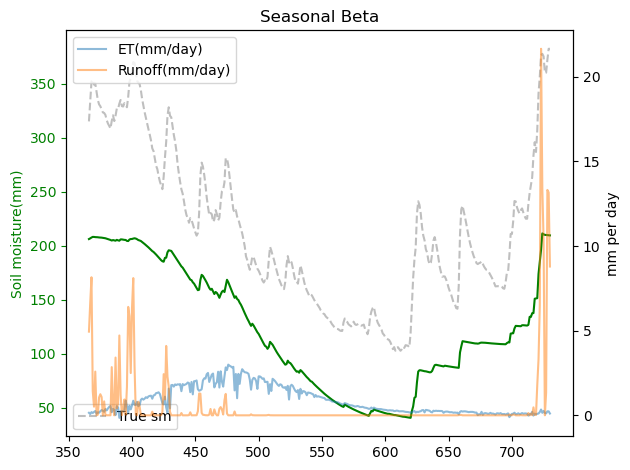

In [73]:
fig, ax = plt.subplots()
ax.set_title('Seasonal Beta')
ax, ax2 = plot_time_series(output_swbm_esp['sm'][year_mask],
                           output_swbm_esp['le'][year_mask],
                           output_swbm_esp['ro'][year_mask], ax)
ax.plot(input_swbm_esp['sm'][year_mask], label='True sm',
        linestyle='dashed', color='grey', alpha=0.5)
ax.set_ylabel('Soil moisture(mm)')
ax.legend()
ax2.legend()
plt.tight_layout()

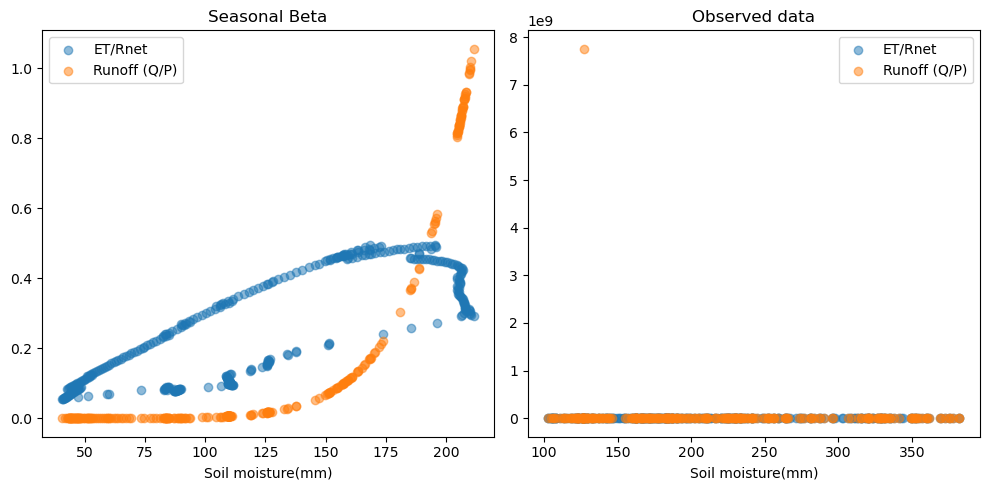

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_title('Seasonal Beta')
ax[0].scatter(output_swbm_esp['sm'][year_mask],
           output_swbm_esp['le'][year_mask] / input_swbm_esp['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[0].scatter(output_swbm_esp['sm'][year_mask],
           output_swbm_esp['ro'][year_mask] / input_swbm_esp['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[0].set_xlabel('Soil moisture(mm)')
ax[0].legend()

ax[1].set_title('Observed data')
ax[1].scatter(input_swbm_esp['sm'][year_mask],
           input_swbm_esp['le'][year_mask] / input_swbm_esp['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[1].scatter(input_swbm_esp['sm'][year_mask],
           input_swbm_esp['ro'][year_mask] / input_swbm_esp['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[1].set_xlabel('Soil moisture(mm)')
ax[1].legend()
plt.tight_layout()

# Sweden

In [75]:
# Run SWBM without seasonal variation
moists, runoffs, ets, _ = predict_ts(input_swbm_swe, const_swbm_params_swe)
eval_df = eval_swbm(input_swbm_swe,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')
eval_df = pd.concat((eval_df, eval_swbm(input_swbm_swe, output_swbm_swe, 'B0 seasonal')))
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,-0.033457,3.394932e-02
1,None\nSeasonal,ro,0.053943,6.244973e-04
2,None\nSeasonal,le,0.879764,0.000000e+00
0,B0 seasonal,sm,0.663433,0.000000e+00
1,B0 seasonal,ro,0.258632,2.043472e-62
2,B0 seasonal,le,0.482919,6.996637e-234


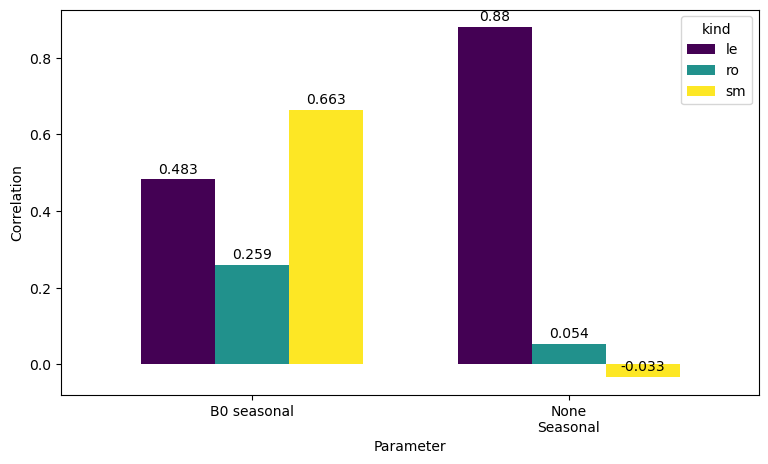

In [76]:
# PLot correlations
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr').sort_values(by='sm', ascending=False)

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(9, 5), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')
plt.xticks(rotation=0)
# Show the plot
plt.show()

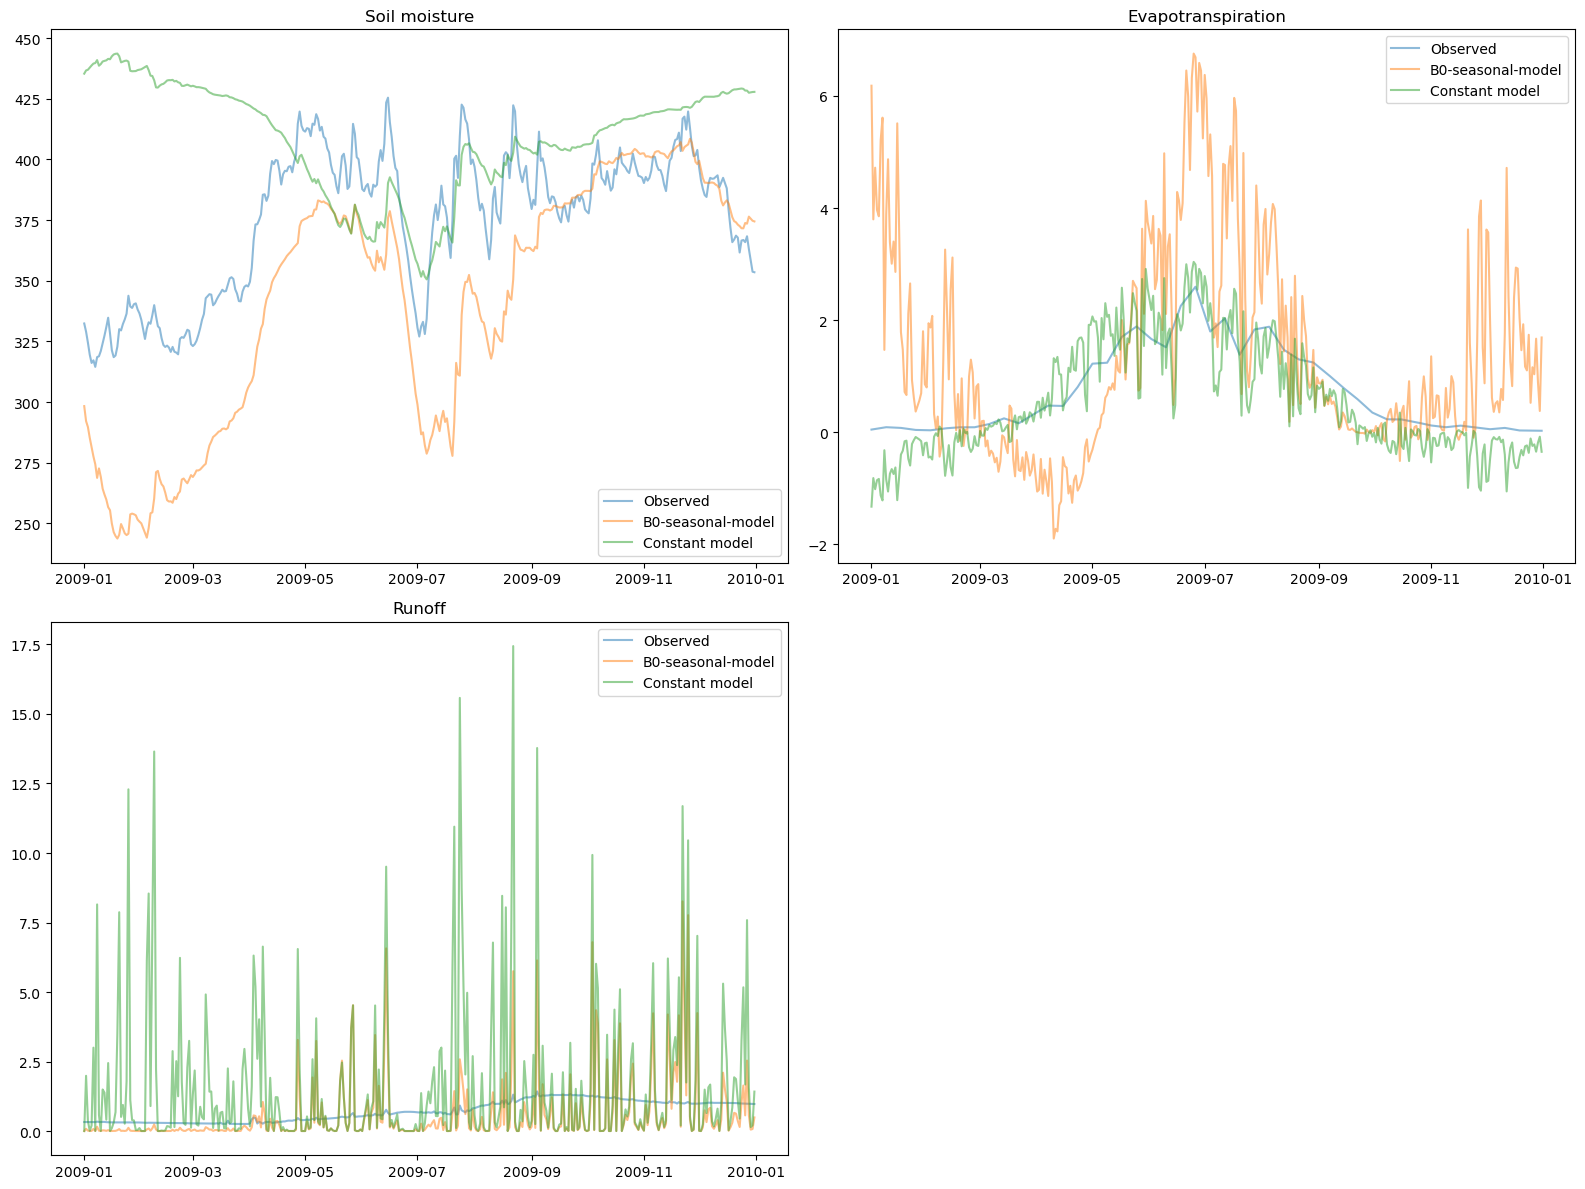

In [77]:
# visualize b0-model vs. constant-model vs. observed
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].plot(x_ticks, input_swbm_swe['sm'][year_mask], label='Observed', alpha=0.5)
ax[0, 0].plot(x_ticks, output_swbm_swe['sm'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 0].plot(x_ticks, moists[year_mask], label='Constant model', alpha=0.5)
ax[0, 0].set_title('Soil moisture')
ax[0, 0].legend()

ax[0, 1].plot(x_ticks, input_swbm_swe['le'][year_mask], label='Observed', alpha=0.5)
ax[0, 1].plot(x_ticks, output_swbm_swe['le'][year_mask],
              label='B0-seasonal-model', alpha=0.5)
ax[0, 1].plot(x_ticks, ets[year_mask], label='Constant model', alpha=0.5)
ax[0, 1].set_title('Evapotranspiration')
ax[0, 1].legend()

ax[1, 0].plot(x_ticks, input_swbm_swe['ro'][year_mask], label='Observed', alpha=0.5)
ax[1, 0].plot(x_ticks, output_swbm_swe['ro'][year_mask], alpha=0.5,
              label='B0-seasonal-model')
ax[1, 0].plot(x_ticks, runoffs[year_mask], label='Constant model', alpha=0.5)
ax[1, 0].set_title('Runoff')
ax[1, 0].legend()

ax[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

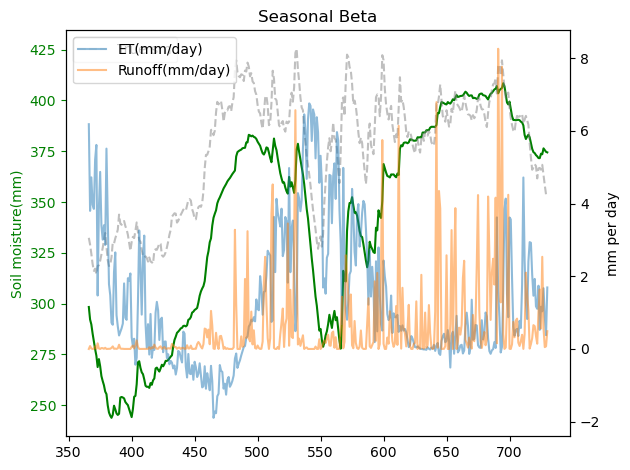

In [78]:
fig, ax = plt.subplots()
ax.set_title('Seasonal Beta')
ax, ax2 = plot_time_series(output_swbm_swe['sm'][year_mask],
                           output_swbm_swe['le'][year_mask],
                           output_swbm_swe['ro'][year_mask], ax)
ax.plot(input_swbm_swe['sm'][year_mask], label='True sm',
        linestyle='dashed', color='grey', alpha=0.5)
ax.set_ylabel('Soil moisture(mm)')
ax.legend()
ax2.legend()
plt.tight_layout()

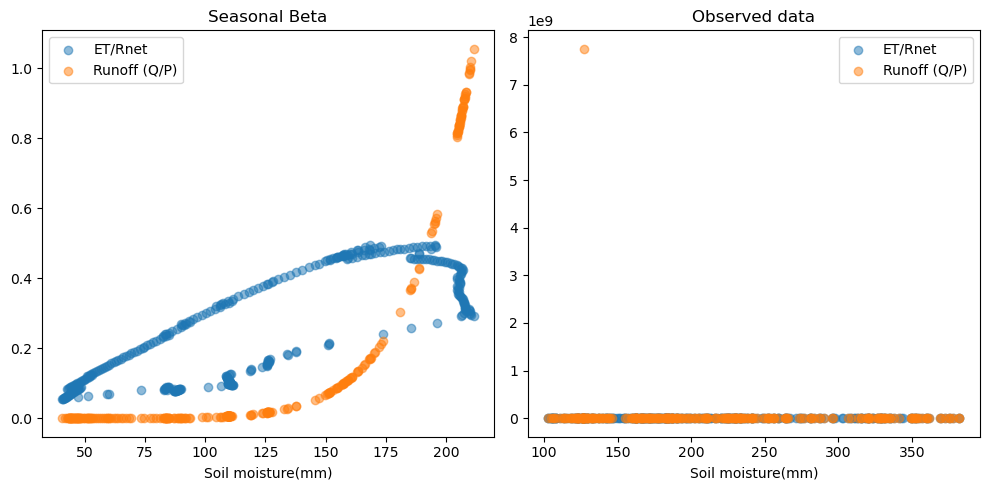

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].set_title('Seasonal Beta')
ax[0].scatter(output_swbm_esp['sm'][year_mask],
           output_swbm_esp['le'][year_mask] / input_swbm_esp['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[0].scatter(output_swbm_esp['sm'][year_mask],
           output_swbm_esp['ro'][year_mask] / input_swbm_esp['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[0].set_xlabel('Soil moisture(mm)')
ax[0].legend()

ax[1].set_title('Observed data')
ax[1].scatter(input_swbm_esp['sm'][year_mask],
           input_swbm_esp['le'][year_mask] / input_swbm_esp['snr'][year_mask],
           label='ET/Rnet', alpha=0.5)
ax[1].scatter(input_swbm_esp['sm'][year_mask],
           input_swbm_esp['ro'][year_mask] / input_swbm_esp['tp'][year_mask],
           label='Runoff (Q/P)', alpha=0.5)
ax[1].set_xlabel('Soil moisture(mm)')
ax[1].legend()
plt.tight_layout()